In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.cluster import KMeans
from collections import Counter

# ==============================
# Mutual Information Estimation Functions
# ==============================
def compute_gram_matrix(X, sigma):
    sum_X = np.sum(X**2, axis=1, keepdims=True)
    dists = sum_X - 2 * np.dot(X, X.T) + sum_X.T
    K = np.exp(-dists / (2 * sigma**2))
    return K

def normalize_gram_matrix(K):
    N = K.shape[0]
    diag = np.sqrt(np.diag(K))
    normalization = np.outer(diag, diag) + 1e-10  # avoid division by zero
    A = K / normalization
    A = A / N
    return A

def compute_entropy_from_gram(A, alpha=1.01):
    eigvals = np.linalg.eigvalsh(A)
    eigvals = np.maximum(eigvals, 0)
    S = 1/(1 - alpha) * np.log(np.sum(eigvals**alpha))
    return S

def compute_MI(X, Y, gamma=1.0, alpha=1.01):
    N, d1 = X.shape
    _, d2 = Y.shape
    eps = 1e-8
    # Normalize columns (counter scale effects)
    X_norm = (X - np.mean(X, axis=0)) / (np.std(X, axis=0) + eps)
    Y_norm = (Y - np.mean(Y, axis=0)) / (np.std(Y, axis=0) + eps)
    sigma_X = gamma * np.sqrt(d1) * (N ** (-1/(4+d1)))
    sigma_Y = gamma * np.sqrt(d2) * (N ** (-1/(4+d2)))
    K_X = compute_gram_matrix(X_norm, sigma_X)
    K_Y = compute_gram_matrix(Y_norm, sigma_Y)
    A_X = normalize_gram_matrix(K_X)
    A_Y = normalize_gram_matrix(K_Y)
    S_X = compute_entropy_from_gram(A_X, alpha)
    S_Y = compute_entropy_from_gram(A_Y, alpha)
    K_joint = K_X * K_Y
    A_joint = normalize_gram_matrix(K_joint)
    S_joint = compute_entropy_from_gram(A_joint, alpha)
    MI = S_X + S_Y - S_joint
    return MI

def get_intermediate_activations(model, x):
    """Pass x through a Sequential model and return a list of layer outputs."""
    activations = []
    out = x
    for layer in model.layers:
        out = layer(out)
        activations.append(out)
    return activations

In [4]:
# ==============================
# Autoencoder Definition
# ==============================
class AutoEncoder(Model):
    def __init__(self, M, num_channels, rate, Eb_N0):
        super(AutoEncoder, self).__init__()
        self.variance = np.sqrt(1/(2 * rate * Eb_N0))
        self.n_channels = num_channels
        self.encoder = Sequential([
            Dense(M, activation='relu', name="encoder_layer1"),
            Dense(num_channels, activation='linear', name="encoder_layer2"),
        ])
        self.decoder = Sequential([
            Dense(M, activation='relu', name="decoder_layer1"),
            Dense(M, activation='softmax', name="decoder_layer2"),
        ])
    def call(self, inputs):
        # Convert integer inputs to one-hot vectors (assumes M is defined globally)
        one_hot = to_categorical(inputs, num_classes=M)
        encoded = self.encoder(one_hot)
        transmitted = np.sqrt(self.n_channels) * tf.math.l2_normalize(encoded, axis=-1)
        noise = self.variance * np.random.randn(transmitted.shape[0], self.n_channels)
        channel_output = transmitted + noise
        output = self.decoder(channel_output)
        return output

In [5]:
# ==============================
# BLER Simulation Functions
# ==============================
def simulate_autoencoder(EbNodB, channel_type, test_one_hot, autoencoder, rate, n_channel):
    EbNo = 10**(EbNodB/10.0)
    sigma = np.sqrt(1/(2*rate*EbNo))
    if channel_type == 'AWGN':
        noise = sigma * np.random.randn(test_one_hot.shape[0], n_channel)
    elif channel_type == 'Laplacian':
        b = sigma/np.sqrt(2)
        noise = np.random.laplace(0, b, size=(test_one_hot.shape[0], n_channel))
    transmitted = autoencoder.encoder.predict(test_one_hot)
    norm_transmitted = np.sqrt(n_channel) * tf.math.l2_normalize(transmitted, axis=-1).numpy()
    channel_out = norm_transmitted + noise
    y_pred = autoencoder.decoder.predict(channel_out)
    pred_labels = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(test_one_hot, axis=1)
    bler = np.mean(pred_labels != true_labels)
    return bler

def hamming74_encode(msg):
    # Convert msg (0-15) to a 4-bit vector
    bits = np.array(list(np.binary_repr(msg, width=4)), dtype=int)
    G = np.array([[1,0,0,0,1,1,0],
                  [0,1,0,0,1,0,1],
                  [0,0,1,0,0,1,1],
                  [0,0,0,1,1,1,1]], dtype=int)
    codeword = np.mod(np.dot(bits, G), 2)
    return codeword

def hamming74_decode(r):
    # r is a binary vector of length 7
    H = np.array([[1,1,0,1,1,0,0],
                  [1,0,1,1,0,1,0],
                  [0,1,1,1,0,0,1]], dtype=int)
    syndrome = np.mod(np.dot(H, r.T), 2)
    syndrome_tuple = tuple(syndrome.tolist())
    for i in range(7):
        col = tuple(H[:, i].tolist())
        if col == syndrome_tuple:
            r[i] = 1 - r[i]
            break
    decoded_bits = r[:4]
    decoded_int = int("".join(decoded_bits.astype(str)), 2)
    return decoded_int

def simulate_hamming(EbNodB, channel_type, N_test=500):
    rate_hamming = 4/7
    EbNo = 10**(EbNodB/10.0)
    sigma = np.sqrt(1/(2 * rate_hamming * EbNo))
    if channel_type == 'AWGN':
        noise_func = lambda shape: sigma * np.random.randn(*shape)
    elif channel_type == 'Laplacian':
        b = sigma/np.sqrt(2)
        noise_func = lambda shape: np.random.laplace(0, b, size=shape)
    errors = 0
    for _ in range(N_test):
        msg = np.random.randint(0, 16)
        cw = hamming74_encode(msg)
        # BPSK modulation: 0 -> +1, 1 -> -1
        tx = np.where(cw==0, 1.0, -1.0)
        noise = noise_func(tx.shape)
        rx = tx + noise
        rx_bits = (rx < 0).astype(int)
        decoded = hamming74_decode(rx_bits.copy())
        if decoded != msg:
            errors += 1
    bler = errors / N_test
    return bler


In [10]:
# ==============================
# Set Seed for Reproducibility
# ==============================
def set_seed(seed: int = 25):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(1024)

# ==============================
# System & Training Parameters
# ==============================
M = 7                # Number of symbols
k = int(np.log2(M))  # Bits per symbol
n_channel = 4
rate = k / n_channel  # Code rate
EbNo_train = 5.0     # Training Eb/N0 in linear scale

print("SYSTEM PARAMETERS:")
print("M:", M, "k:", k, "n_channel:", n_channel, "rate:", rate, "EbNo_train:", EbNo_train)

# Training parameters
epochs = 25
batch_size = 128
lr = 0.002
N_train = 2000
N_val = 500

print("TRAINING PARAMETERS:")
print("epochs:", epochs, "batch_size:", batch_size, "N_train:", N_train, "N_val:", N_val)

# ==============================
# Data Generation for Autoencoder
# ==============================
train_data = np.random.randint(M, size=N_train)
train_label = to_categorical(train_data, num_classes=M)
val_data = np.random.randint(M, size=N_val)
val_label = to_categorical(val_data, num_classes=M)

# ==============================
# Instantiate Autoencoder Model
# ==============================
autoencoder = AutoEncoder(M, n_channel, rate, EbNo_train)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# Metric objects
train_loss_metrics = tf.keras.metrics.Mean()
train_acc_metrics = tf.keras.metrics.CategoricalAccuracy()
val_loss_metrics = tf.keras.metrics.Mean()
val_acc_metrics = tf.keras.metrics.CategoricalAccuracy()

# For MI estimation use a fixed batch from validation set.
val_batch = val_data[:batch_size]
val_batch_one_hot = to_categorical(val_batch, num_classes=M)

# Dictionaries to store MI for each layer (for both channels)
mi_input_awgn = { "layer1": [], "layer2": [], "layer3": [], "layer4": [] }
mi_output_awgn = { "layer1": [], "layer2": [], "layer3": [], "layer4": [] }
mi_input_lap = { "layer1": [], "layer2": [], "layer3": [], "layer4": [] }
mi_output_lap = { "layer1": [], "layer2": [], "layer3": [], "layer4": [] }

epoch_train_loss = []
epoch_val_loss = []
bler_history = []  # To track BLER on training data per epoch

# ------------------------------
# Define Training and Validation Steps
# ------------------------------
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = autoencoder(x)
        loss_value = loss_fn(y, predictions)
    gradients = tape.gradient(loss_value, autoencoder.trainable_weights)
    optimizer.apply_gradients(zip(gradients, autoencoder.trainable_weights))
    train_loss_metrics(loss_value)
    train_acc_metrics(y, predictions)

@tf.function
def valid_step(x, y):
    predictions = autoencoder(x)
    loss_value = loss_fn(y, predictions)
    val_loss_metrics(loss_value)
    val_acc_metrics(y, predictions)


SYSTEM PARAMETERS:
M: 7 k: 2 n_channel: 4 rate: 0.5 EbNo_train: 5.0
TRAINING PARAMETERS:
epochs: 25 batch_size: 128 N_train: 2000 N_val: 500


In [11]:
# ==============================
# Training Loop with MI Probing and BLER Tracking
# ==============================
for epoch in range(epochs):
    # Reset metrics
    train_loss_metrics.reset_state()
    train_acc_metrics.reset_state()
    val_loss_metrics.reset_state()
    val_acc_metrics.reset_state()

    # Training mini-batches
    for i in range(N_train // batch_size):
        x_batch = train_data[i*batch_size:(i+1)*batch_size]
        y_batch = train_label[i*batch_size:(i+1)*batch_size]
        train_step(x_batch, y_batch)

    valid_step(val_data, val_label)
    epoch_train_loss.append(train_loss_metrics.result().numpy())
    epoch_val_loss.append(val_loss_metrics.result().numpy())

    # ---- Mutual Information Estimation ----
    # Input is the one-hot validation batch.
    x_in = val_batch_one_hot  # shape (batch_size, M)
    # Encoder activations:
    enc_acts = get_intermediate_activations(autoencoder.encoder, x_in)
    a1 = enc_acts[0].numpy().reshape(batch_size, -1)  # layer1
    a2 = enc_acts[1].numpy().reshape(batch_size, -1)  # layer2

    # Compute transmitted signal from encoder output.
    transmitted = np.sqrt(n_channel) * tf.math.l2_normalize(enc_acts[1], axis=-1).numpy()

    # ---- Define two channel types: AWGN and Laplacian ----
    noise_awgn = autoencoder.variance * np.random.randn(batch_size, n_channel)
    channel_awgn = transmitted + noise_awgn
    b = autoencoder.variance / np.sqrt(2)
    noise_lap = np.random.laplace(0, b, size=(batch_size, n_channel))
    channel_lap = transmitted + noise_lap

    # Get decoder activations for AWGN channel:
    dec_acts_awgn = get_intermediate_activations(autoencoder.decoder, channel_awgn)
    a3_awgn = dec_acts_awgn[0].numpy().reshape(batch_size, -1)  # layer3
    a4_awgn = dec_acts_awgn[1].numpy().reshape(batch_size, -1)  # layer4 (final output)
    y_awgn = a4_awgn  # final output for AWGN

    # Get decoder activations for Laplacian channel:
    dec_acts_lap = get_intermediate_activations(autoencoder.decoder, channel_lap)
    a3_lap = dec_acts_lap[0].numpy().reshape(batch_size, -1)  # layer3
    a4_lap = dec_acts_lap[1].numpy().reshape(batch_size, -1)  # layer4 (final output)
    y_lap = a4_lap  # final output for Laplacian

    # Full chain activations (list of layers):
    layers_awgn = [a1, a2, a3_awgn, a4_awgn]
    layers_lap = [a1, a2, a3_lap, a4_lap]

    # For each layer, compute MI:
    for idx, label in enumerate(["layer1", "layer2", "layer3", "layer4"]):
        # For AWGN channel:
        mi_in_awgn = compute_MI(x_in, layers_awgn[idx], gamma=1.0)
        mi_out_awgn = compute_MI(layers_awgn[idx], y_awgn, gamma=1.0)
        mi_input_awgn[label].append(mi_in_awgn)
        mi_output_awgn[label].append(mi_out_awgn)
        # For Laplacian channel:
        mi_in_lap = compute_MI(x_in, layers_lap[idx], gamma=1.0)
        mi_out_lap = compute_MI(layers_lap[idx], y_lap, gamma=1.0)
        mi_input_lap[label].append(mi_in_lap)
        mi_output_lap[label].append(mi_out_lap)

    # ---- BLER Tracking on Training Data ----
    preds_epoch = autoencoder(train_data)
    errors = np.sum(np.argmax(preds_epoch, axis=1) != train_data)
    bler_epoch = errors / N_train
    bler_history.append(bler_epoch)

    # Print statistics for the epoch
    template = (
        "Epoch: {:2d}, Train Loss: {:.5f}, Train Acc: {:.2f}%, Val Loss: {:.5f}, Val Acc: {:.2f}%\n"
        "AWGN MI (Input): L1: {:.3f}, L2: {:.3f}, L3: {:.3f}, L4: {:.3f}\n"
        "AWGN MI (Output): L1: {:.3f}, L2: {:.3f}, L3: {:.3f}, L4: {:.3f}\n"
        "Laplacian MI (Input): L1: {:.3f}, L2: {:.3f}, L3: {:.3f}, L4: {:.3f}\n"
        "Laplacian MI (Output): L1: {:.3f}, L2: {:.3f}, L3: {:.3f}, L4: {:.3f}\n"
        "Training BLER: {:.4f}\n"
    )
    print(template.format(
        epoch+1,
        train_loss_metrics.result(),
        train_acc_metrics.result()*100,
        val_loss_metrics.result(),
        val_acc_metrics.result()*100,
        mi_input_awgn["layer1"][-1], mi_input_awgn["layer2"][-1],
        mi_input_awgn["layer3"][-1], mi_input_awgn["layer4"][-1],
        mi_output_awgn["layer1"][-1], mi_output_awgn["layer2"][-1],
        mi_output_awgn["layer3"][-1], mi_output_awgn["layer4"][-1],
        mi_input_lap["layer1"][-1], mi_input_lap["layer2"][-1],
        mi_input_lap["layer3"][-1], mi_input_lap["layer4"][-1],
        mi_output_lap["layer1"][-1], mi_output_lap["layer2"][-1],
        mi_output_lap["layer3"][-1], mi_output_lap["layer4"][-1],
        bler_epoch
    ))


Epoch:  1, Train Loss: 1.99478, Train Acc: 9.27%, Val Loss: 1.91159, Val Acc: 13.60%
AWGN MI (Input): L1: 1.873, L2: 1.855, L3: 1.148, L4: 1.049
AWGN MI (Output): L1: 1.032, L2: 1.034, L3: 1.756, L4: 1.873
Laplacian MI (Input): L1: 1.873, L2: 1.855, L3: 1.153, L4: 1.021
Laplacian MI (Output): L1: 1.005, L2: 1.008, L3: 1.699, L4: 1.777
Training BLER: 0.8340

Epoch:  2, Train Loss: 1.81952, Train Acc: 20.89%, Val Loss: 1.75182, Val Acc: 26.20%
AWGN MI (Input): L1: 1.875, L2: 1.826, L3: 1.102, L4: 0.982
AWGN MI (Output): L1: 0.968, L2: 0.959, L3: 1.745, L4: 1.815
Laplacian MI (Input): L1: 1.875, L2: 1.826, L3: 1.150, L4: 1.024
Laplacian MI (Output): L1: 1.008, L2: 1.003, L3: 1.743, L4: 1.782
Training BLER: 0.7295

Epoch:  3, Train Loss: 1.67728, Train Acc: 33.96%, Val Loss: 1.60935, Val Acc: 40.40%
AWGN MI (Input): L1: 1.878, L2: 1.818, L3: 1.208, L4: 1.100
AWGN MI (Output): L1: 1.085, L2: 1.071, L3: 1.724, L4: 1.724
Laplacian MI (Input): L1: 1.878, L2: 1.818, L3: 1.178, L4: 1.126
Laplaci

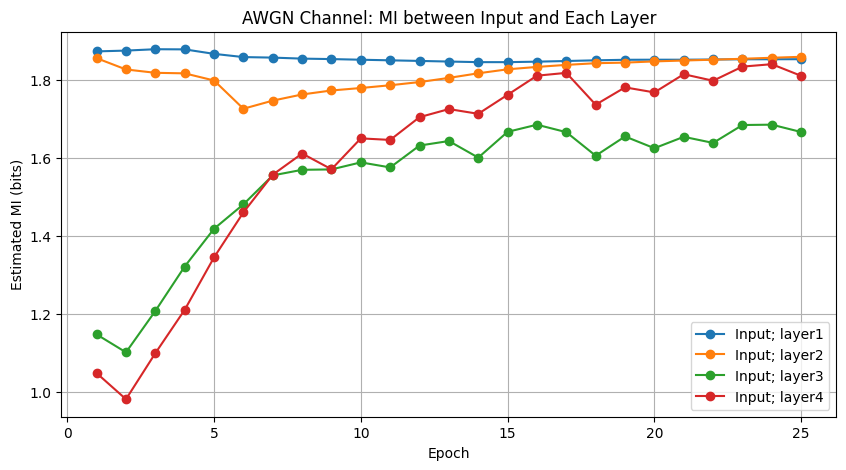

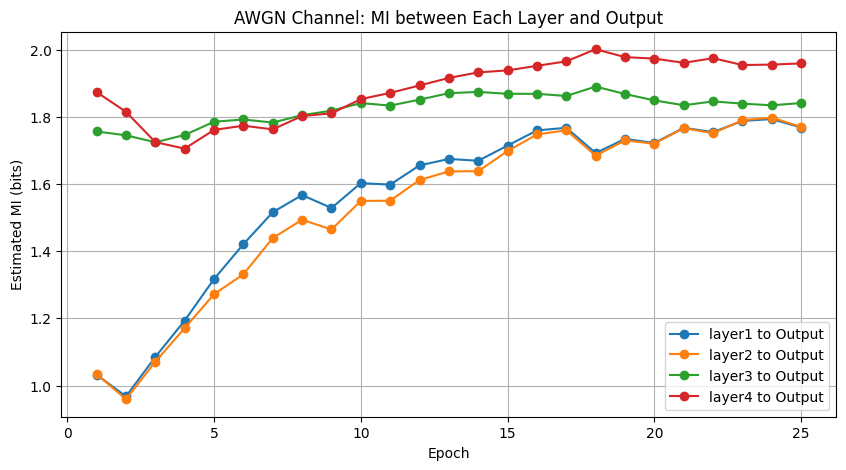

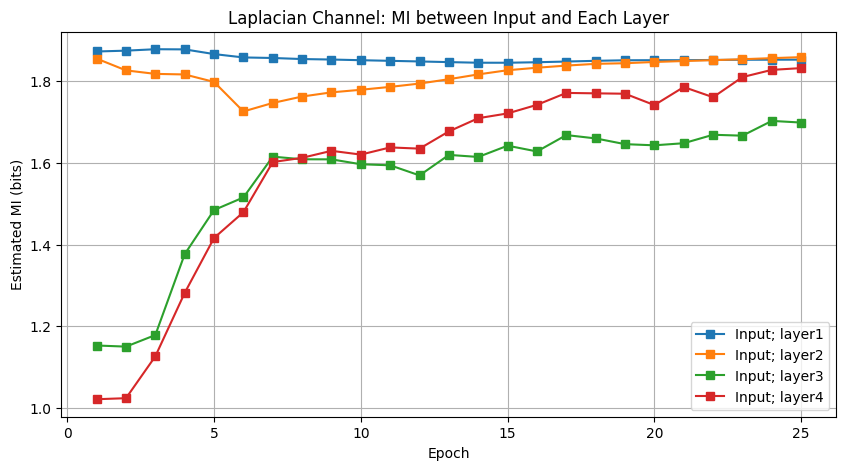

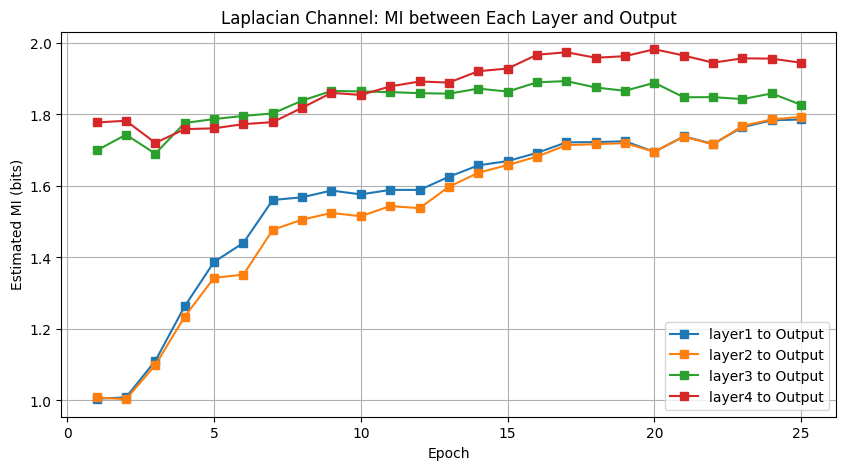

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Eb/N0: -2.00 dB | Autoencoder AWGN BLER: 0.4500, Laplacian BLER: 0.3580 | Hamming AWGN BLER: 0.3920, Laplacian BLER: 0.2920
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Eb/N0: -1.00 dB | Autoencoder AWGN BLER: 0.3740, Laplacian BLER: 0.3340 | Hamming AWGN BLER: 0.3500, Laplacian BLER: 0.2580
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Eb/N0: 0.00 dB | Autoencoder AWGN BLER: 0.3400, Laplacian BLER: 0.2520 | Hamming AWGN BLER: 0.2540, Laplacian BLER: 0.2140
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s

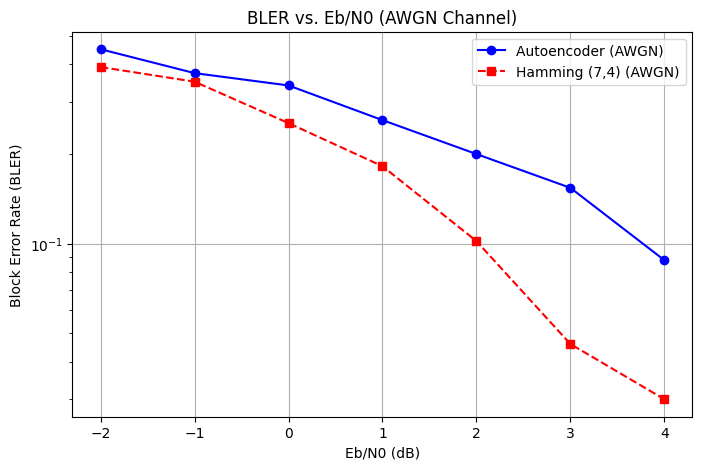

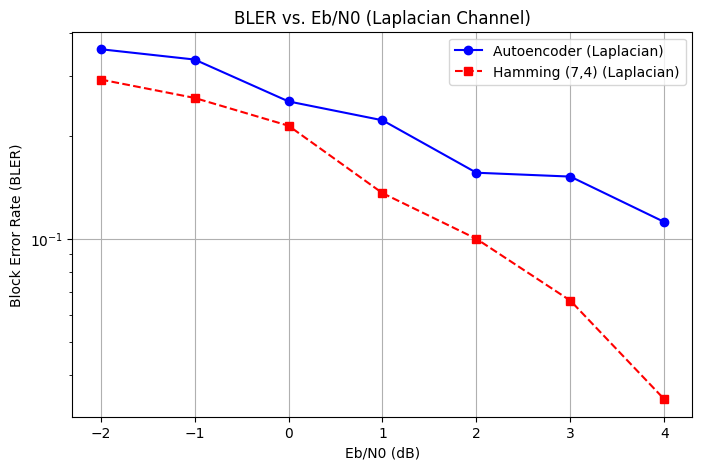

In [12]:







# ==============================
# Plot MI vs. Epoch for AWGN Channel
# ==============================
epochs_range = np.arange(1, epochs+1)
layers = ["layer1", "layer2", "layer3", "layer4"]

plt.figure(figsize=(10, 5))
for label in layers:
    plt.plot(epochs_range, mi_input_awgn[label], marker='o', label=f'Input; {label}')
plt.xlabel('Epoch')
plt.ylabel('Estimated MI (bits)')
plt.title('AWGN Channel: MI between Input and Each Layer')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
for label in layers:
    plt.plot(epochs_range, mi_output_awgn[label], marker='o', label=f'{label} to Output')
plt.xlabel('Epoch')
plt.ylabel('Estimated MI (bits)')
plt.title('AWGN Channel: MI between Each Layer and Output')
plt.legend()
plt.grid()
plt.show()

# ==============================
# Plot MI vs. Epoch for Laplacian Channel
# ==============================
plt.figure(figsize=(10, 5))
for label in layers:
    plt.plot(epochs_range, mi_input_lap[label], marker='s', label=f'Input; {label}')
plt.xlabel('Epoch')
plt.ylabel('Estimated MI (bits)')
plt.title('Laplacian Channel: MI between Input and Each Layer')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
for label in layers:
    plt.plot(epochs_range, mi_output_lap[label], marker='s', label=f'{label} to Output')
plt.xlabel('Epoch')
plt.ylabel('Estimated MI (bits)')
plt.title('Laplacian Channel: MI between Each Layer and Output')
plt.legend()
plt.grid()
plt.show()

# ==============================
# BLER vs. Eb/N0 Simulation
# ==============================
EbNodB_range = np.arange(-2, 5, 1)
N_test_auto = 500
test_auto = np.random.randint(M, size=N_test_auto)
test_auto_onehot = to_categorical(test_auto, num_classes=M)
N_test_hamming = 500

bler_auto_awgn = []
bler_auto_lap = []
bler_hamming_awgn = []
bler_hamming_lap = []

for EbNodB in EbNodB_range:
    bler_auto_awgn.append(simulate_autoencoder(EbNodB, 'AWGN', test_auto_onehot, autoencoder, rate, n_channel))
    bler_auto_lap.append(simulate_autoencoder(EbNodB, 'Laplacian', test_auto_onehot, autoencoder, rate, n_channel))
    bler_hamming_awgn.append(simulate_hamming(EbNodB, 'AWGN', N_test_hamming))
    bler_hamming_lap.append(simulate_hamming(EbNodB, 'Laplacian', N_test_hamming))
    print("Eb/N0: {:.2f} dB | Autoencoder AWGN BLER: {:.4f}, Laplacian BLER: {:.4f} | Hamming AWGN BLER: {:.4f}, Laplacian BLER: {:.4f}".format(
          EbNodB, bler_auto_awgn[-1], bler_auto_lap[-1], bler_hamming_awgn[-1], bler_hamming_lap[-1]))

plt.figure(figsize=(8,5))
plt.plot(EbNodB_range, bler_auto_awgn, 'bo-', label='Autoencoder (AWGN)')
plt.plot(EbNodB_range, bler_hamming_awgn, 'rs--', label='Hamming (7,4) (AWGN)')
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Block Error Rate (BLER)')
plt.title('BLER vs. Eb/N0 (AWGN Channel)')
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(EbNodB_range, bler_auto_lap, 'bo-', label='Autoencoder (Laplacian)')
plt.plot(EbNodB_range, bler_hamming_lap, 'rs--', label='Hamming (7,4) (Laplacian)')
plt.yscale('log')
plt.xlabel('Eb/N0 (dB)')
plt.ylabel('Block Error Rate (BLER)')
plt.title('BLER vs. Eb/N0 (Laplacian Channel)')
plt.grid()
plt.legend()
plt.show()



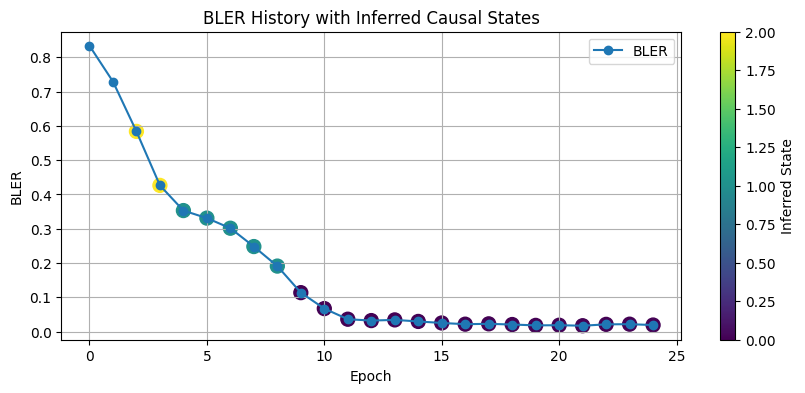

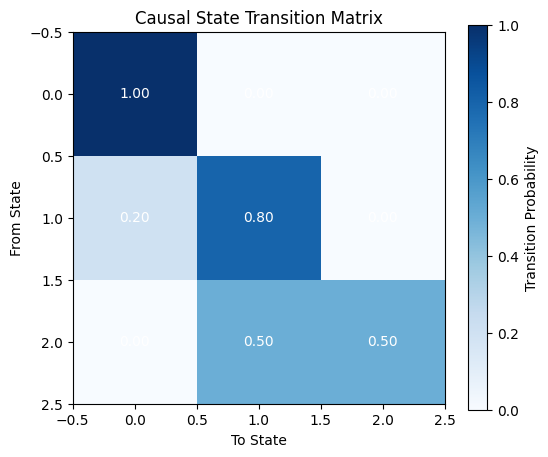

In [13]:
# ==============================
# Causal State Reconstruction on BLER History
# ==============================
# Use BLER history collected over epochs from training
embedding_dim = 3  # Number of consecutive BLER values to embed
embedded_vectors = np.array([
    bler_history[i:i + embedding_dim]
    for i in range(len(bler_history) - embedding_dim + 1)
])

n_states = 3
kmeans = KMeans(n_clusters=n_states, random_state=42)
states = kmeans.fit_predict(embedded_vectors)

# Construct transition matrix from inferred states
adjacency_matrix = np.zeros((n_states, n_states))
for (s_from, s_to) in zip(states[:-1], states[1:]):
    adjacency_matrix[s_from, s_to] += 1
transition_matrix = adjacency_matrix / (adjacency_matrix.sum(axis=1, keepdims=True) + 1e-10)

# Plot BLER history with inferred states (using the states for the embedded segments)
plt.figure(figsize=(10, 4))
# The first (embedding_dim-1) epochs are not assigned a state; we align the states to epochs starting from embedding_dim-1
plt.plot(bler_history, '-o', label='BLER')
plt.scatter(np.arange(embedding_dim - 1, epochs), bler_history[embedding_dim - 1:],
            c=states, cmap='viridis', s=100)
plt.colorbar(label='Inferred State')
plt.xlabel('Epoch')
plt.ylabel('BLER')
plt.title('BLER History with Inferred Causal States')
plt.grid(True)
plt.legend()
plt.show()

# Visualize transition matrix
plt.figure(figsize=(6, 5))
plt.imshow(transition_matrix, cmap='Blues')
plt.colorbar(label='Transition Probability')
plt.xlabel('To State')
plt.ylabel('From State')
plt.title('Causal State Transition Matrix')
for i in range(n_states):
    for j in range(n_states):
        plt.text(j, i, f'{transition_matrix[i, j]:.2f}', ha='center', va='center', color='white')
plt.show()
